# MAY 2022 - KAGGLE TABULAR PLAYGROUND
Given manufacturing control data, predict whether the machine is in state 0 or 1.

todo:
- outlier detection
- removal of f28, other feature engineering
- visualizing prediction results, confusion matrix

## Import Libraries

In [14]:
import pandas as pd
import numpy as np
import sklearn as skl
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import ensemble, neighbors, linear_model, svm

plt.style.use('dark_background')
warnings.filterwarnings('ignore')

## Import Data

In [15]:
df = pd.read_csv('train.csv')

fields = [field for field in df.columns if field[:2] == "f_"]

## Initial EDA

Error at ax: (6, 2)
Note: 1 error is expected.


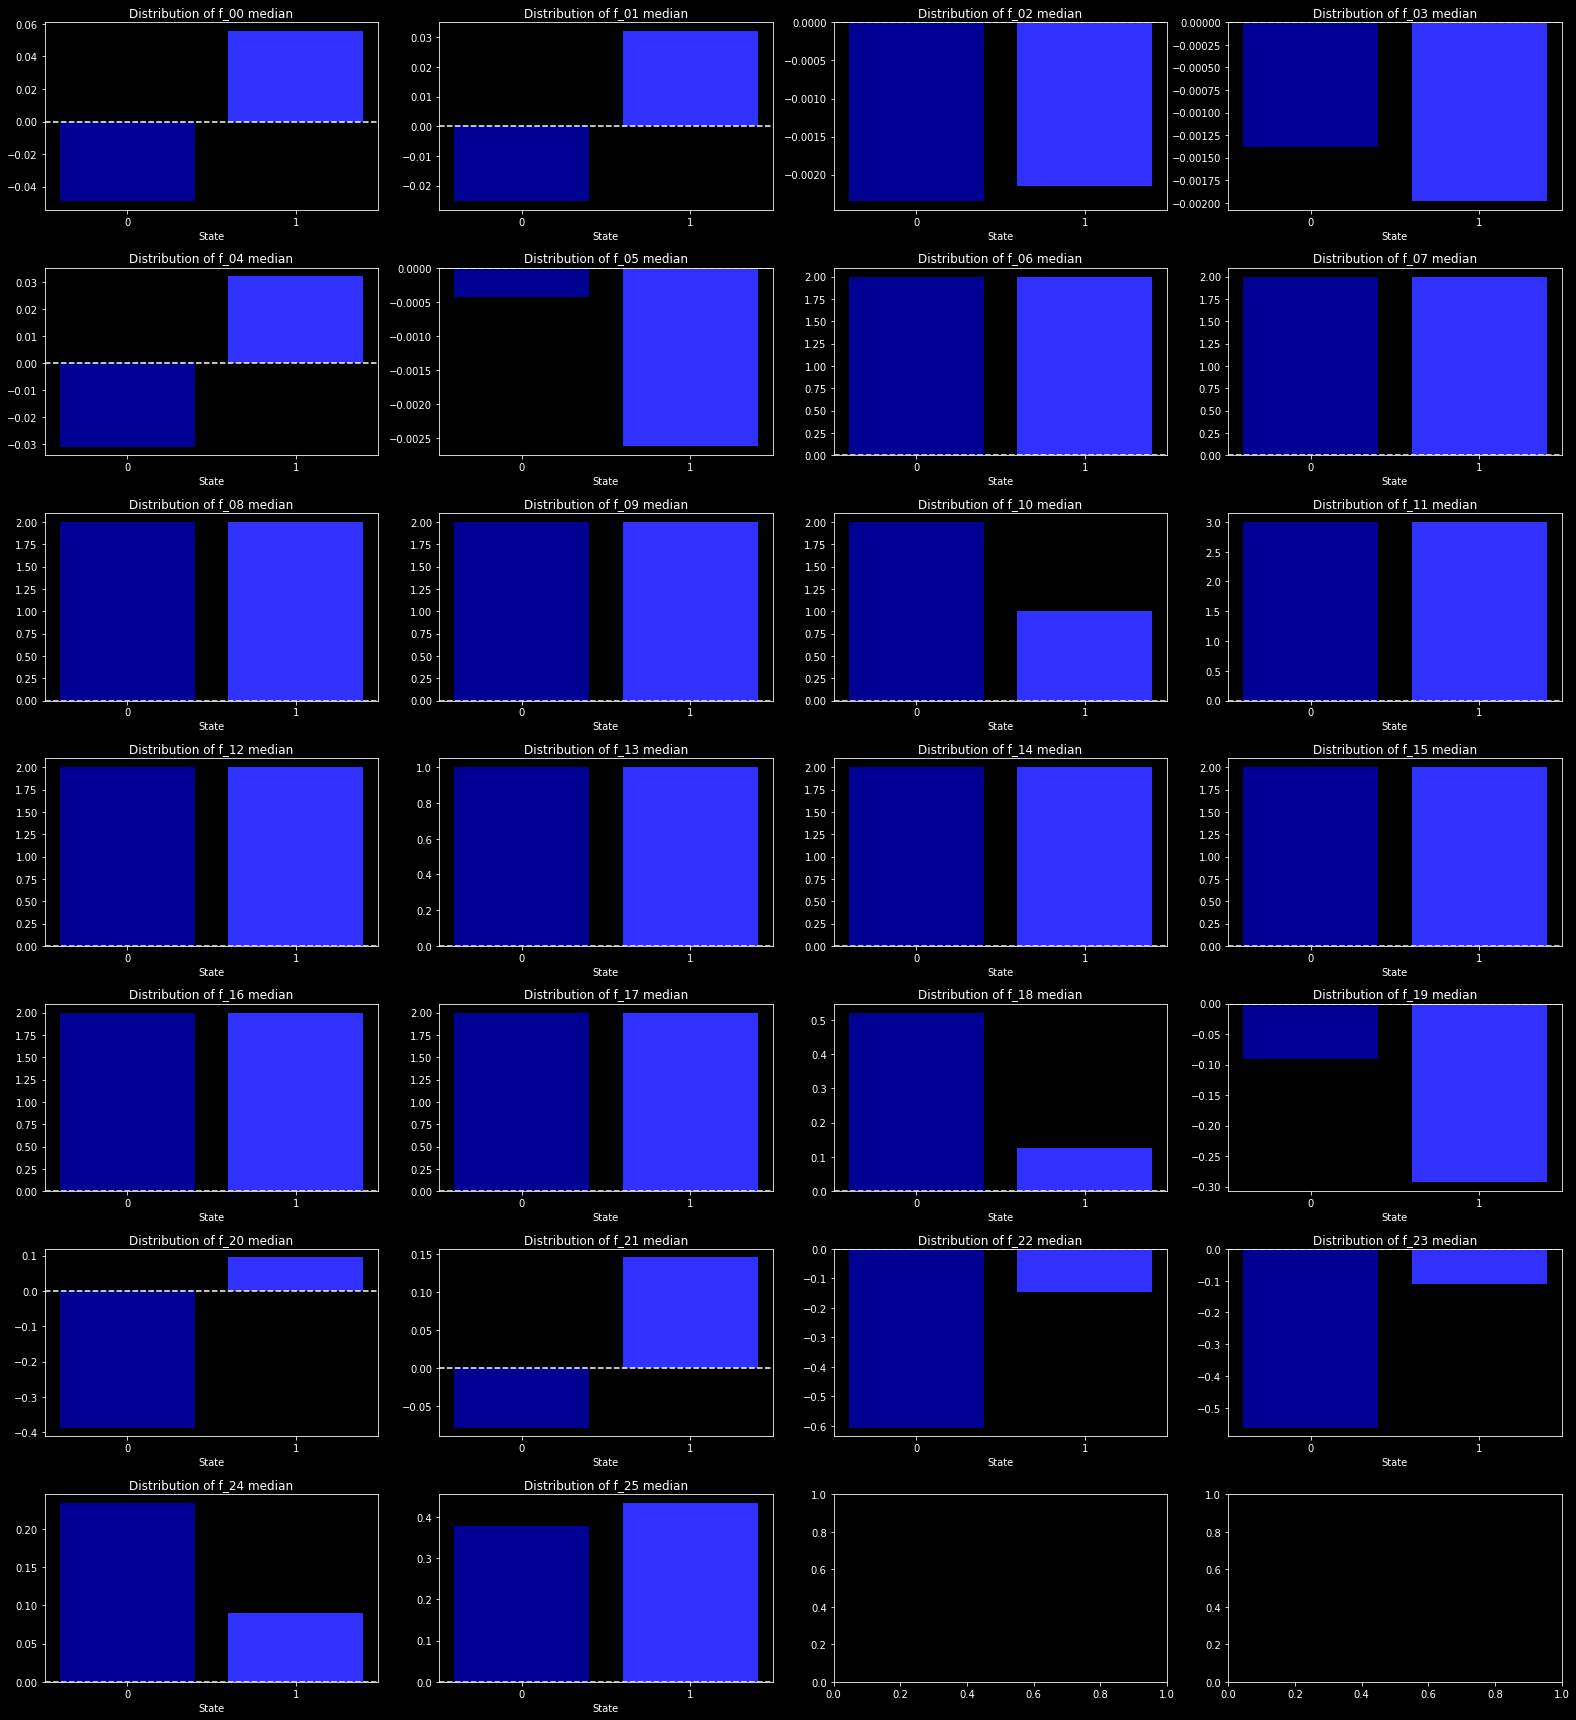

In [16]:
df_group = df.groupby('target').median()

# sns.scatterplot(df['f_00'], df['target'], color='lightblue', ax=ax[0], alpha=0.05)

def make_bar(i, j, n):
    ''' Makes a matplotlib bar chart of its distribution per state for each features'''
    
    ax[i,j].bar(
        x=[0,1], 
        height=pd.Series(df_group[fields[n]]), 
        color=plt.cm.seismic(np.linspace(0.1,0.3,2))
        )
    
    ax[i, j].axhline(y=0, color='white', linestyle='--')
    
    colname = df_group.columns[n]
    ax[i,j].set_xticks([0,1])
    ax[i,j].set_xlabel(f"State")
    ax[i,j].set_title(f"Distribution of {colname} median")
    

l = len(fields)
fig, ax = plt.subplots(l//4, 4)
i = 0

for n in range(1, l-5, 4): # Iterates through each subplot row
    try:
        for j in range(4): # Iterates through each chart/plot
            make_bar(i, j, n+j)
        i += 1
    except:
        print(f"Error at ax: ({i}, {j})")
print("Note: 1 error is expected.")

fig.set_figwidth(22)
fig.set_figheight(4*i)
fig.tight_layout()
fig.show()

Conclusion of median/mean distribution of features:
...

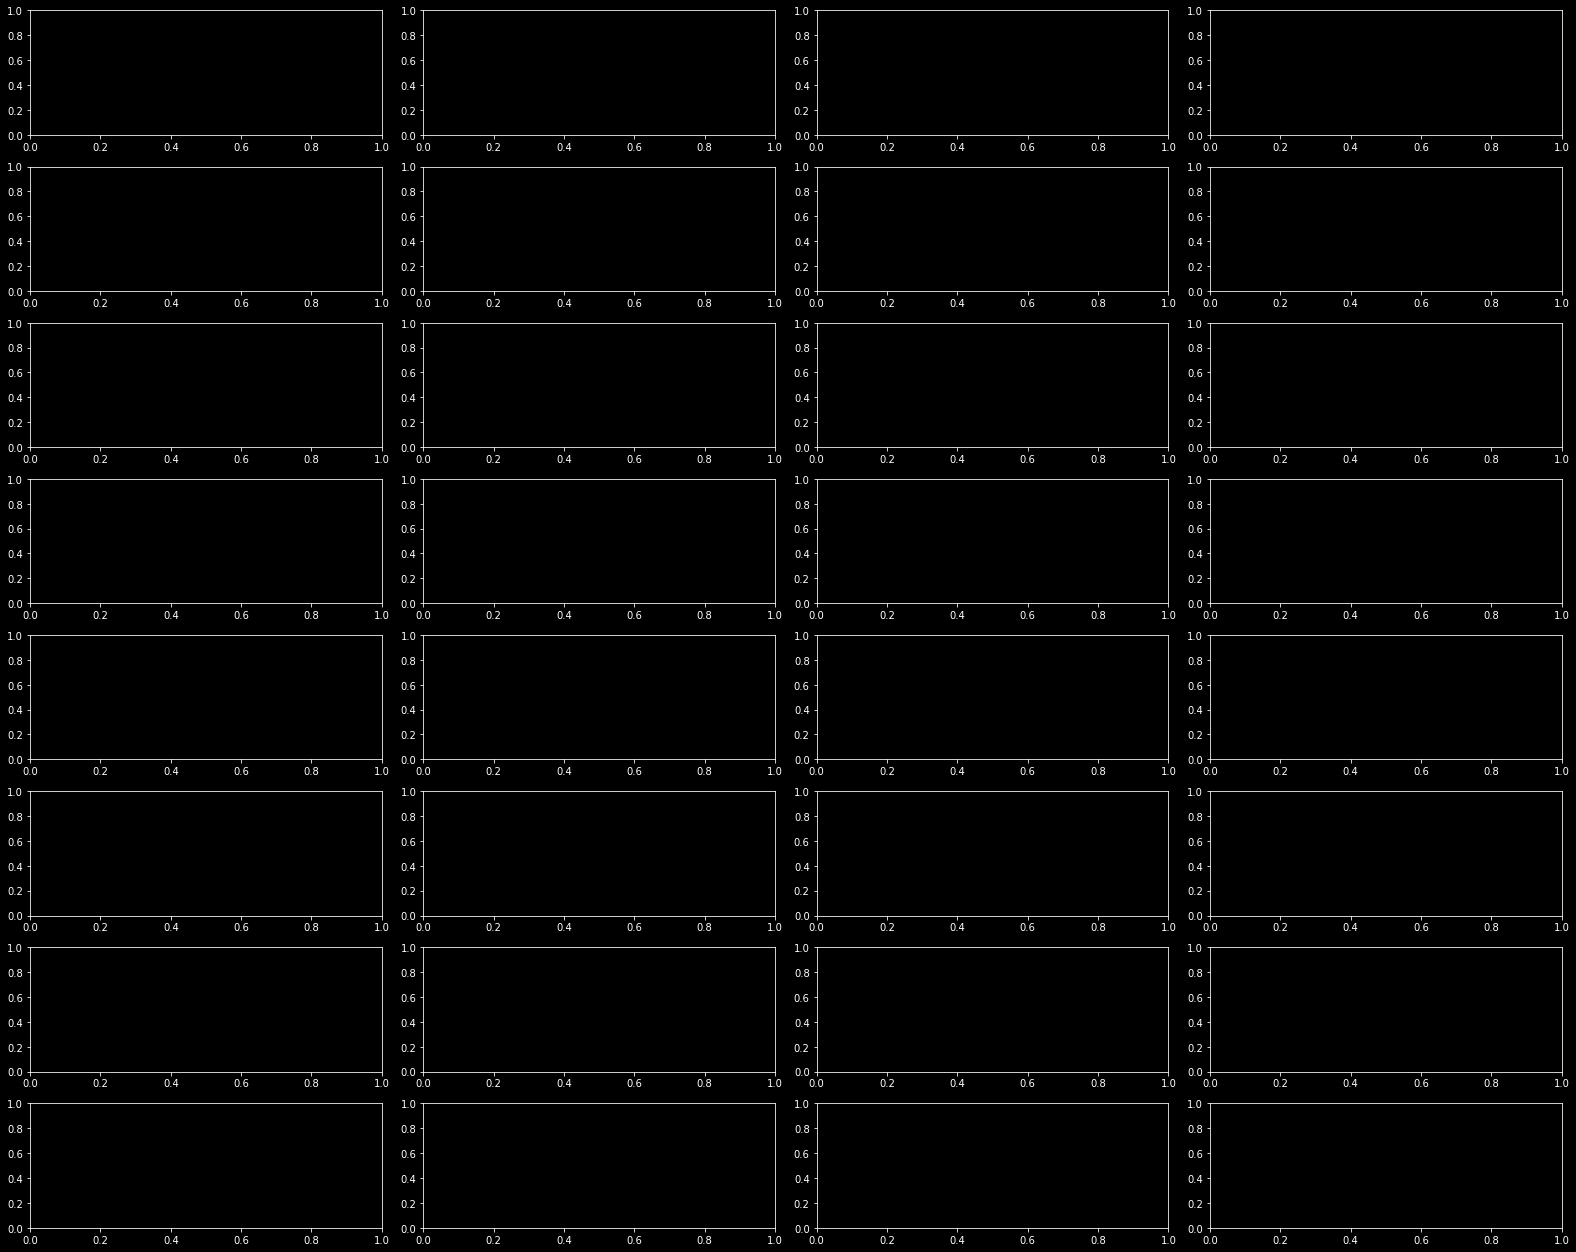

In [17]:
# Correlation between features

def make_corr_plot(x_name, y_name, i):
    x, y = df[x_name], df[y_name]
    corr = np.corrcoef(x, y)[0][1]
    ax[i//4,i%4].scatter(x, y, alpha=0.5)
    ax[i//4,i%4].set_title(f"Corr {x_name} and {y_name}: {corr:.4f}")
    ax[i//4,i%4].set_xlabel(x_name)
    ax[i//4,i%4].set_ylabel(fields[i])

fig, ax = plt.subplots(8, 4)
FOCUS_FEATURE = 'target'

for i in range(0, 0):
    if (i == 27): # TODO: we cant check for f_27 unless we do some feature engineering
        continue
    make_corr_plot(FOCUS_FEATURE, fields[i], i)
    
fig.set_figwidth(22)
fig.set_figheight(l//4*2.5)
fig.tight_layout()
fig.show()

Results of correlation check:
- 'target' does not seem to be correlated with any fields in particular???
- f_28 seems to be correlated with f_00 to f_06. seems to be the only column worth removing
- categorical features seem to have a particular pattern graphically, but statistically no correlation

<br> some other, more irrelevant stuff:
- f_11 seems to have SOME correlation with a few other features, but NOT ENOUGH to prove anything..
- f_21 & f_25 has consistently weak correlations with a few other features.

In [18]:
df['f_27'].describe()

count         900000
unique        741354
top       BBBBBBCJBC
freq              12
Name: f_27, dtype: object

How to interprety f27... it's so abstract T_T
<br> ideas:
- char to unicode char value
- char to value, weighted by position
- just use the lazy ordinal encoding
- make dummy column to encode for each character (e.g. 10 dummy columns, each corresponds to 1 letter)
- ..

In [25]:
enc = preprocessing.OrdinalEncoder()
f27 = pd.DataFrame().empty

def convert_f_27(data):
    ''' Returns transformed dataFrame 'data' with dummy columns of f_27'''
    f27 = pd.DataFrame(data['f_27'].unique()) # will be re-merged with data later
    f27.rename(columns={0: 'f_27'}, inplace=True)

    code_len = 10
    for i in range(code_len): # Iterates through each letter, to create a dummy column
        f27[f'f27_{i}'] = f27['f_27'].str[i]
        f27[f'f27_{i}'] = enc.fit_transform(f27[f'f27_{i}'].values.reshape(-1,1))
    # f27.drop(columns=['f_27'], inplace=True)

    data = data.merge(f27, on='f_27', how='left')
    data.drop(columns=['f_27'], inplace=True)
    return data
    
df = convert_f_27(df)

KeyError: 'f_27'

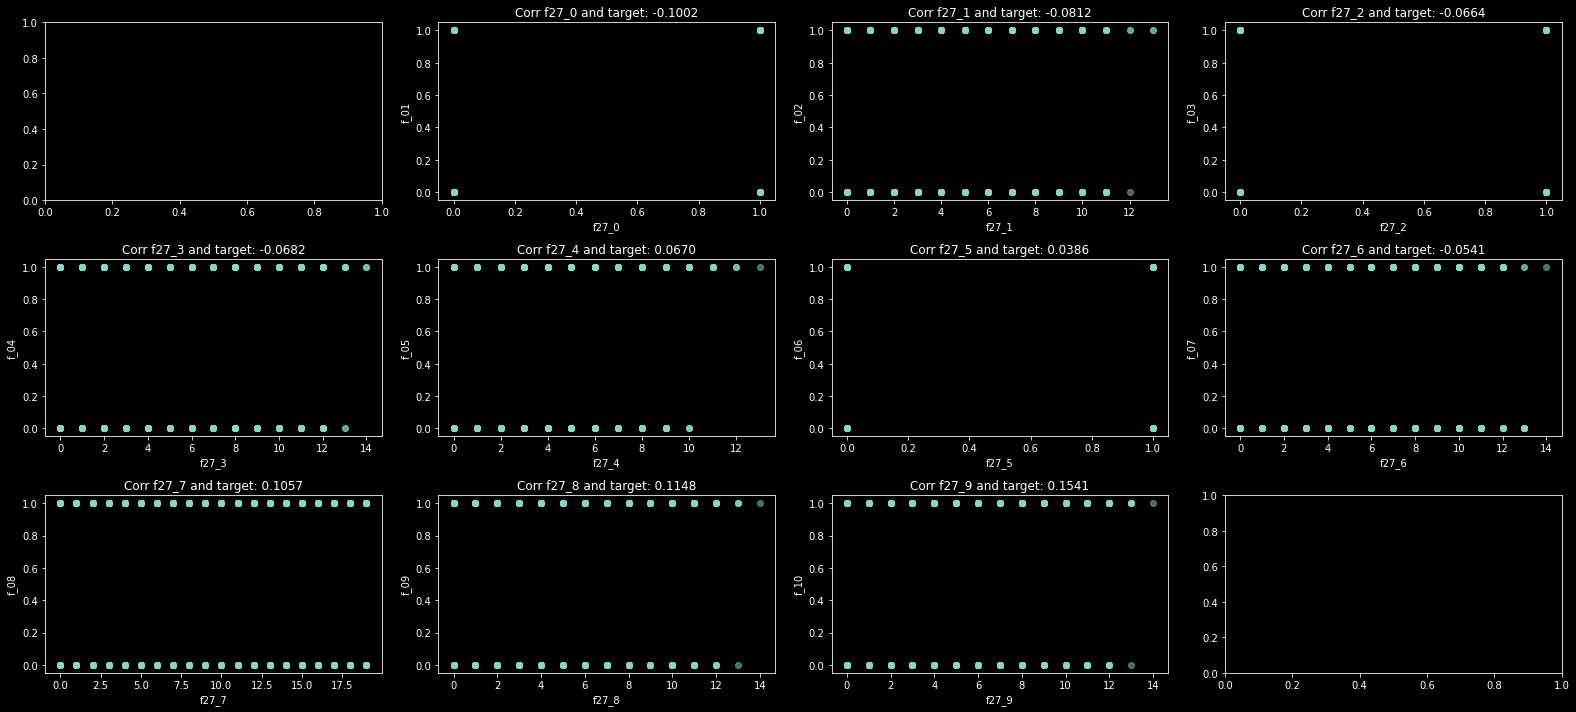

In [ ]:
fig,ax = plt.subplots(3, 4)

for i in range(1, len(f27.columns)):
    make_corr_plot(f27.columns[i], 'target', i)
    
fig.set_figheight(i)
fig.set_figwidth(22)
fig.tight_layout()
fig.show()

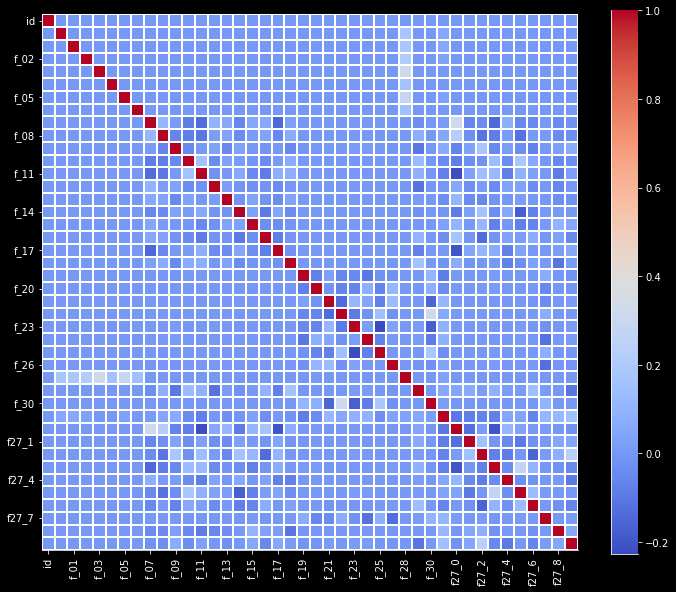

In [26]:
g = sns.heatmap(
    df.corr(method='spearman'),
    cmap='coolwarm', 
    square=True, 
    linewidths=0.01)
sns.despine()
g.figure.set_size_inches(12, 10)

plt.show()

Note: heatmap above doesn't show categorical features (i think) because target just won't show up...
but nevertheless this proves my hypothesis. only f_28 will be removed in feature engineering

## Preprocessing & Feature Engineering

Initial feature engineering ideas:
- convert categorical fields
- removing/limiting outliers (n missing values)
- removing correlated features

In [27]:
DUMMY_RUN = False

In [28]:
def preprocess(data):
    ''' Return pre-processed version of data (in dataFrame)
    EXCEPTION: f_27 processing'''
    return data

In [29]:
y = df.pop('target')

preprocess(df)
X = df.drop(columns=['f_28'])

In [30]:
if DUMMY_RUN:
    X_train, X_test, y_train, y_test \
    = model_selection.train_test_split(X, y, train_size=0.4, test_size=0.15, random_state=2)
    
else:
    test = pd.read_csv('test.csv')
    test = convert_f_27(test)
    preprocess(test)
    
    X_train = X
    y_train = y
    X_test = test

## Forecast

In [ ]:
scores = dict()
classifiers = {
    'RandomForest': ensemble.RandomForestClassifier(),
    # 'RandomFor2': ensemble.RandomForestClassifier(criterion='entropy'),
    'AdaBoost': ensemble.AdaBoostClassifier(),
    'LogisticRegression': skl.linear_model.LogisticRegression(),
    'ExtraTrees': ensemble.ExtraTreesClassifier(),
    'KNN': neighbors.KNeighborsClassifier()
    # 'SVC': svm.SVC() # please for the love of god dont try to wait 3 years for svc to finish
}
choice = 'RandomForest'

if DUMMY_RUN:
    for name in classifiers:
        c = classifiers[name]
        
        c.fit(X_train, y_train)
        y_pred = c.predict(X_test)
        scores[name] = metrics.accuracy_score(y_pred,y_test)
else:
    c = classifiers[choice]
    c.fit(X_train, y_train)
    y_pred = c.predict(X_test)

In [32]:
X_test = X_test.drop(columns=['f_28'])
y_pred = c.predict(X_test)

## Metrics / Export

In [33]:
if DUMMY_RUN:
    print(scores)
else:
    output = pd.DataFrame({'id': X_test['id'].values, 'target': y_pred})
    output.to_csv('pred.csv', index=False)

KeyError: 'sequence'